In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [41]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dense = nn.Linear(4800, 2400)
        self.dense2 = nn.Linear(2400, 1200)
        self.dense3 = nn.Linear(1200,600)
        self.dense4 = nn.Linear(600, 300)
        self.dense5 = nn.Linear(300,1)

    def forward(self, input):
        d1 = F.sigmoid(self.dense(input.flatten(start_dim=1,end_dim=2)))
        d2 = F.sigmoid(self.dense2(d1))
        d3 = F.sigmoid(self.dense3(d2))
        d4 = F.sigmoid(self.dense4(d3))
        d5 = self.dense5(d4)
        return d5

In [42]:
def seq_to_one_hot(seq):
    indexes = {"A": 0, "C": 1, "G": 2, "T": 3, "U": 3}
    encoded_seq = torch.zeros([4, len(seq)])
    for i, nuc in enumerate(seq):
        encoded_seq[indexes[nuc], i] = 1
    return encoded_seq.unsqueeze(0)

In [43]:
def count_a(seq):
    return seq.count("A")

In [57]:
nucs = ["A","C","G","T"]
sequences_train = ["".join(random.choices(nucs,k=1200,weights=[random.random() for i in range(4)])) for _ in range(20000)]
sequences_test = ["".join(random.choices(nucs,k=1200,weights=[random.random() for i in range(4)])) for _ in range(1000)]

encoded_sequences_train = torch.tensor(np.array([seq_to_one_hot(seq) for seq in sequences_train])).squeeze().float()
encoded_sequences_test = torch.tensor(np.array([seq_to_one_hot(seq) for seq in sequences_test])).squeeze().float()

In [66]:
net = Net()
epochs = 20
optim = torch.optim.AdamW(params = net.parameters())
loss_fn = nn.MSELoss(reduction='mean')
Xtrain = encoded_sequences_train
Ytrain = torch.tensor([count_a(seq)/1200 for seq in sequences_train]).float().unsqueeze(dim=1)
Xtest = encoded_sequences_test
Ytest = torch.tensor([count_a(seq)/1200 for seq in sequences_test]).float().unsqueeze(dim=1)
dataset = torch.utils.data.TensorDataset(Xtrain,Ytrain)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=20,shuffle=True)

In [67]:
for e in range(epochs):
    net.eval()
    predTest = net(Xtest)
    predTrain = net(Xtrain)
    lossTest = loss_fn(predTest,Ytest).item()
    loss_fn.zero_grad()
    lossTrain = loss_fn(predTrain,Ytrain).item()
    loss_fn.zero_grad()
    print(e,lossTrain, lossTest)

    net.train()
    for i, (batch_X, batch_Y) in enumerate(dataloader):
        pred = net(batch_X)
        loss = loss_fn(pred,batch_Y)
        loss.backward()
        optim.step()
        optim.zero_grad()

0 0.08257370442152023 0.0847623273730278
1 0.0001573176559759304 0.0001397174346493557
2 0.0001752826210577041 0.00016533376765437424
3 0.00018597525195218623 0.00016138558567035943
4 7.4596973718144e-05 6.668328569503501e-05
5 0.00013340408622752875 0.00012147071538493037
6 0.0005674465792253613 0.0005723879439756274
7 0.0002397809730609879 0.0002290115662617609
8 0.00028519672923721373 0.0002587645431049168
9 0.00011257386358920485 0.00011005921987816691
10 0.00013087484694551677 0.00011751787678804249
11 0.00016160155064426363 0.00016138747741933912
12 6.217274494701996e-05 5.173210593056865e-05
13 0.0001025729434331879 9.696696361061186e-05
14 0.0001575328060425818 0.0001557794021209702
15 5.732738281949423e-05 5.124231756781228e-05
16 6.200915231602266e-05 5.2386745664989576e-05
17 9.298715303884819e-05 9.160028275800869e-05
18 0.00012551773397717625 0.0001173873824882321
19 0.0001824745995691046 0.00018576144066173583


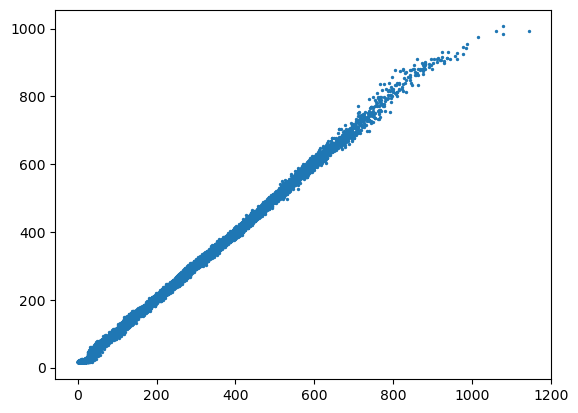

In [68]:
plt.figure()
plt.scatter(Ytrain.numpy()*1200,net(Xtrain).detach().numpy()*1200,s=2)

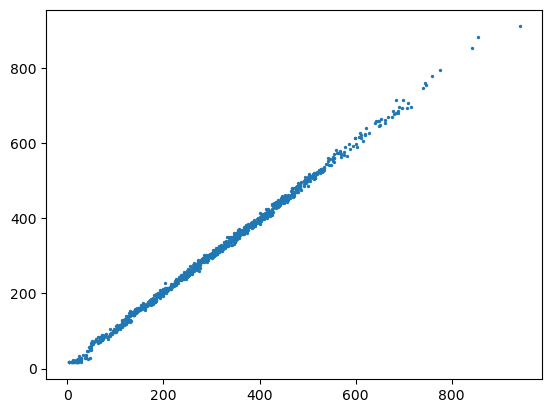

In [69]:
plt.figure()
plt.scatter(Ytest.numpy()*1200,net(Xtest).detach().numpy()*1200,s=2)

In [70]:
torch.save(net.state_dict(), 'models/first_model.pth')

In [72]:
model = Net()
model.load_state_dict(torch.load('models/first_model.pth', weights_only=True))

<All keys matched successfully>

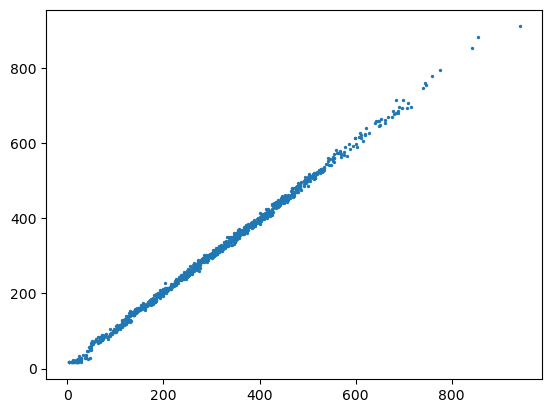

In [73]:
plt.figure()
plt.scatter(Ytest.numpy()*1200,model(Xtest).detach().numpy()*1200,s=2)

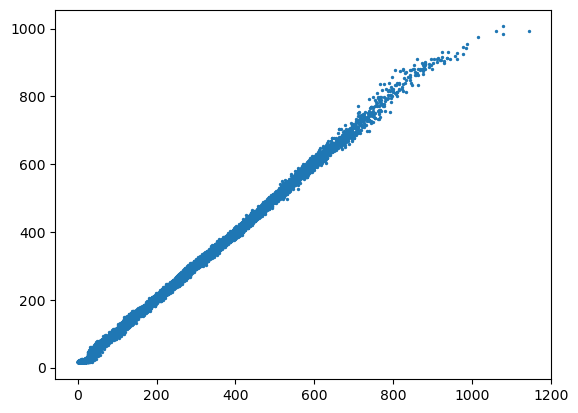

In [74]:
plt.figure()
plt.scatter(Ytrain.numpy()*1200,model(Xtrain).detach().numpy()*1200,s=2)